In [10]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import json
from model_training_process import *
import requests
import matplotlib.pyplot as plt
import os

檔名音調: ' ', 2, 3, 4
訓練標籤:  1 , 2, 3, 4, 5

In [11]:
# data_accent_label = list()
# for npy_file in tqdm(npy_file_path_list_selected):
#     pinyin = npy_file.split("_")[1]
#     accent_label = int(pinyin[-1] if pinyin[-1].isdigit() else 1)
#     data_accent_label.append(accent_label)
# data_accent_label = np.array(data_accent_label)
# print(f"data_accent_label.shape = {data_accent_label.shape}")

In [12]:
class_df = pd.read_csv("..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df[["pinyin", "class_label"]]

,pinyin,class_label
0,zhi,0
1,chi,0
2,shi,0
3,ri,0
4,zi,1
...,...,...
402,xun,20
403,yong,18
404,jiong,20
405,qiong,20


In [13]:
class_df['class_label_index'] = class_df.groupby('class_label').cumcount()
class_df[["pinyin", "class_label", "class_label_index"]]

,pinyin,class_label,class_label_index
0,zhi,0,0
1,chi,0,1
2,shi,0,2
3,ri,0,3
4,zi,1,0
...,...,...,...
402,xun,20,11
403,yong,18,4
404,jiong,20,12
405,qiong,20,13


In [14]:
npy_file_path_list = glob("..\\..\\data\\*EduVer\\*")
print(f"len(npy_file_path_list): {len(npy_file_path_list)}")

len(npy_file_path_list): 67173


In [15]:
selected_npy_file_path_list = list()
for npy_file_path in npy_file_path_list:
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        selected_npy_file_path_list.append(npy_file_path)
print(f"len(selected_npy_file_path_list): {len(selected_npy_file_path_list)}")

len(selected_npy_file_path_list): 66852


In [16]:
dic = dict()

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = list()
    dic[f"class_{i}_accent_label_index_list"] = list()

for npy_file_path in tqdm(selected_npy_file_path_list):
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    accent_label = int(pinyin[-1] if pinyin[-1].isdigit() else 1)
    
    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].values[0]
    # class_label_index = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label_index"].values[0]
    # print(f"{pinyin_non_accent}, {class_label}, {class_label_index}")

    mfcc_matrix = np.load(npy_file_path)
    dic[f"class_{class_label}_mfcc_matrix_list"].append(mfcc_matrix)
    dic[f"class_{class_label}_accent_label_index_list"].append(accent_label)

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = np.array(dic[f"class_{i}_mfcc_matrix_list"])
    dic[f"class_{i}_accent_label_index_list"] = np.array(dic[f"class_{i}_accent_label_index_list"])

for i in range(len(class_df.groupby("class_label").count().index)):
    print(f"class_{i}_mfcc_matrix_list.shape: {dic[f'class_{i}_mfcc_matrix_list'].shape}")
    print(f"class_{i}_accent_label_index_list.shape: {dic[f'class_{i}_accent_label_index_list'].shape}")

100%|██████████| 66852/66852 [01:40<00:00, 662.68it/s]

class_0_mfcc_matrix_list.shape: (3133, 13, 44)
class_0_accent_label_index_list.shape: (3133,)
class_1_mfcc_matrix_list.shape: (844, 13, 44)
class_1_accent_label_index_list.shape: (844,)
class_2_mfcc_matrix_list.shape: (1322, 13, 44)
class_2_accent_label_index_list.shape: (1322,)
class_3_mfcc_matrix_list.shape: (5333, 13, 44)
class_3_accent_label_index_list.shape: (5333,)
class_4_mfcc_matrix_list.shape: (7255, 13, 44)
class_4_accent_label_index_list.shape: (7255,)
class_5_mfcc_matrix_list.shape: (4499, 13, 44)
class_5_accent_label_index_list.shape: (4499,)
class_6_mfcc_matrix_list.shape: (6060, 13, 44)
class_6_accent_label_index_list.shape: (6060,)
class_7_mfcc_matrix_list.shape: (3050, 13, 44)
class_7_accent_label_index_list.shape: (3050,)
class_8_mfcc_matrix_list.shape: (3167, 13, 44)
class_8_accent_label_index_list.shape: (3167,)
class_9_mfcc_matrix_list.shape: (2396, 13, 44)
class_9_accent_label_index_list.shape: (2396,)
class_10_mfcc_matrix_list.shape: (4181, 13, 44)
class_10_accen

In [17]:
channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2

In [22]:
model_train_info_list = list()
model_list = list()

for i in tqdm(range(len(class_df.groupby("class_label").count().index))):
    
    best_params = json.load(
        open(
            file=f"..\\..\\grid_search\\method2_with_fake_data\\layer3\\best_parameters_record\\best_parameters_class{i}.json",
            mode="r"
        )
    )

    learning_rate = best_params["learning_rate"]
    num_filters = best_params["num_filters"]
    dense_units = best_params["dense_unit"]
    batch_size = best_params["batch_size"]
    epochs = best_params["epochs"]
    
    X = dic[f"class_{i}_mfcc_matrix_list"]
    y = dic[f"class_{i}_accent_label_index_list"]
    
    mfcc_dim_1 = X.shape[1]
    mfcc_dim_2 = X.shape[2]
    
    X_train, X_test, y_train, y_test = get_processed_data(
        X=X,
        y=y,
        num_classes=num_classes,
        mfcc_dim_1=mfcc_dim_1,
        mfcc_dim_2=mfcc_dim_2,
        channel=channel,
        test_size=test_size,
    )

    model = get_cnn_model(
        input_shape=(mfcc_dim_1, mfcc_dim_2, channel),
        num_classes=num_classes,
        learning_rate=learning_rate,
        num_filters=num_filters,
        dense_units=dense_units
    )
    
    model_train_info = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        validation_data=(X_test, y_test)
    )
    
    model_train_info_list.append(model_train_info)
    model_list.append(model)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/500
79/79 - 1s - loss: 5.7594 - accuracy: 0.1085 - val_loss: 6.1487 - val_accuracy: 0.0016 - 1s/epoch - 17ms/step
Epoch 2/500
79/79 - 0s - loss: 4.8155 - accuracy: 0.4130 - val_loss: 6.0339 - val_accuracy: 0.1292 - 428ms/epoch - 5ms/step
Epoch 3/500
79/79 - 0s - loss: 4.1108 - accuracy: 0.5020 - val_loss: 5.7629 - val_accuracy: 0.1244 - 434ms/epoch - 5ms/step
Epoch 4/500
79/79 - 0s - loss: 3.5838 - accuracy: 0.5200 - val_loss: 5.2000 - val_accuracy: 0.1419 - 415ms/epoch - 5ms/step
Epoch 5/500
79/79 - 0s - loss: 3.0325 - accuracy: 0.5443 - val_loss: 4.4347 - val_accuracy: 0.1675 - 439ms/epoch - 6ms/step
Epoch 6/500
79/79 - 0s - loss: 2.5872 - accuracy: 0.5678 - val_loss: 3.8979 - val_accuracy: 0.2488 - 444ms/epoch - 6ms/step
Epoch 7/500
79/79 - 0s - loss: 2.2502 - accuracy: 0.5778 - val_loss: 3.3916 - val_accuracy: 0.4928 - 445ms/epoch - 6ms/step
Epoch 8/500
79/79 - 0s - loss: 1.9861 - accuracy: 0.5754 - val_loss: 2.8719 - val_accuracy: 0.5742 - 428ms/epoch - 5ms/step
Epoch 9/50

  5%|▍         | 1/21 [03:38<1:12:59, 218.96s/it]

Epoch 1/250
22/22 - 1s - loss: 3.4211 - accuracy: 0.3393 - val_loss: 5.0835 - val_accuracy: 0.3905 - 722ms/epoch - 33ms/step
Epoch 2/250
22/22 - 0s - loss: 1.4356 - accuracy: 0.4637 - val_loss: 3.3677 - val_accuracy: 0.1124 - 124ms/epoch - 6ms/step
Epoch 3/250
22/22 - 0s - loss: 1.3603 - accuracy: 0.4741 - val_loss: 2.2760 - val_accuracy: 0.1598 - 105ms/epoch - 5ms/step
Epoch 4/250
22/22 - 0s - loss: 1.2973 - accuracy: 0.4504 - val_loss: 1.6986 - val_accuracy: 0.4201 - 108ms/epoch - 5ms/step
Epoch 5/250
22/22 - 0s - loss: 1.3163 - accuracy: 0.4607 - val_loss: 1.6933 - val_accuracy: 0.2367 - 111ms/epoch - 5ms/step
Epoch 6/250
22/22 - 0s - loss: 1.3066 - accuracy: 0.4444 - val_loss: 1.4315 - val_accuracy: 0.4497 - 106ms/epoch - 5ms/step
Epoch 7/250
22/22 - 0s - loss: 1.3141 - accuracy: 0.4474 - val_loss: 1.5222 - val_accuracy: 0.3728 - 107ms/epoch - 5ms/step
Epoch 8/250
22/22 - 0s - loss: 1.2609 - accuracy: 0.4770 - val_loss: 1.4445 - val_accuracy: 0.4497 - 106ms/epoch - 5ms/step
Epoch 9

 10%|▉         | 2/21 [04:06<33:44, 106.57s/it]  

Epoch 1/500
9/9 - 1s - loss: 3.5228 - accuracy: 0.2706 - val_loss: 5.2270 - val_accuracy: 0.2604 - 747ms/epoch - 83ms/step
Epoch 2/500
9/9 - 0s - loss: 1.4886 - accuracy: 0.3349 - val_loss: 3.5677 - val_accuracy: 0.2566 - 68ms/epoch - 8ms/step
Epoch 3/500
9/9 - 0s - loss: 1.3884 - accuracy: 0.3784 - val_loss: 2.6743 - val_accuracy: 0.3472 - 71ms/epoch - 8ms/step
Epoch 4/500
9/9 - 0s - loss: 1.3409 - accuracy: 0.3671 - val_loss: 2.2235 - val_accuracy: 0.2151 - 72ms/epoch - 8ms/step
Epoch 5/500
9/9 - 0s - loss: 1.3475 - accuracy: 0.3737 - val_loss: 1.9635 - val_accuracy: 0.3547 - 70ms/epoch - 8ms/step
Epoch 6/500
9/9 - 0s - loss: 1.3230 - accuracy: 0.3851 - val_loss: 1.8865 - val_accuracy: 0.2189 - 66ms/epoch - 7ms/step
Epoch 7/500
9/9 - 0s - loss: 1.3293 - accuracy: 0.3841 - val_loss: 1.6665 - val_accuracy: 0.3434 - 73ms/epoch - 8ms/step
Epoch 8/500
9/9 - 0s - loss: 1.2861 - accuracy: 0.3936 - val_loss: 1.5983 - val_accuracy: 0.1736 - 66ms/epoch - 7ms/step
Epoch 9/500
9/9 - 0s - loss: 1

 14%|█▍        | 3/21 [04:41<22:05, 73.63s/it] 

Epoch 1/250
67/67 - 1s - loss: 3.2867 - accuracy: 0.3022 - val_loss: 3.7609 - val_accuracy: 0.2268 - 1s/epoch - 19ms/step
Epoch 2/250
67/67 - 0s - loss: 1.5499 - accuracy: 0.3877 - val_loss: 2.1408 - val_accuracy: 0.2465 - 473ms/epoch - 7ms/step
Epoch 3/250
67/67 - 0s - loss: 1.3422 - accuracy: 0.4215 - val_loss: 1.7893 - val_accuracy: 0.2652 - 463ms/epoch - 7ms/step
Epoch 4/250
67/67 - 0s - loss: 1.2655 - accuracy: 0.4564 - val_loss: 1.8611 - val_accuracy: 0.2530 - 462ms/epoch - 7ms/step
Epoch 5/250
67/67 - 0s - loss: 1.2027 - accuracy: 0.4754 - val_loss: 1.8471 - val_accuracy: 0.3224 - 476ms/epoch - 7ms/step
Epoch 6/250
67/67 - 0s - loss: 1.1788 - accuracy: 0.4857 - val_loss: 1.6894 - val_accuracy: 0.3365 - 491ms/epoch - 7ms/step
Epoch 7/250
67/67 - 0s - loss: 1.1175 - accuracy: 0.5305 - val_loss: 1.5597 - val_accuracy: 0.3768 - 495ms/epoch - 7ms/step
Epoch 8/250
67/67 - 0s - loss: 1.0768 - accuracy: 0.5420 - val_loss: 1.3406 - val_accuracy: 0.4292 - 486ms/epoch - 7ms/step
Epoch 9/25

 19%|█▉        | 4/21 [06:40<25:57, 91.62s/it]

Epoch 1/500
46/46 - 1s - loss: 1.6512 - accuracy: 0.4733 - val_loss: 2.3410 - val_accuracy: 0.4294 - 882ms/epoch - 19ms/step
Epoch 2/500
46/46 - 0s - loss: 1.1401 - accuracy: 0.5350 - val_loss: 1.5971 - val_accuracy: 0.4045 - 268ms/epoch - 6ms/step
Epoch 3/500
46/46 - 0s - loss: 1.0400 - accuracy: 0.5796 - val_loss: 1.4895 - val_accuracy: 0.4335 - 267ms/epoch - 6ms/step
Epoch 4/500
46/46 - 0s - loss: 0.9907 - accuracy: 0.6077 - val_loss: 1.5146 - val_accuracy: 0.3598 - 265ms/epoch - 6ms/step
Epoch 5/500
46/46 - 0s - loss: 0.9346 - accuracy: 0.6189 - val_loss: 1.3469 - val_accuracy: 0.4914 - 262ms/epoch - 6ms/step
Epoch 6/500
46/46 - 0s - loss: 0.9075 - accuracy: 0.6387 - val_loss: 1.1799 - val_accuracy: 0.5003 - 269ms/epoch - 6ms/step
Epoch 7/500
46/46 - 0s - loss: 0.8584 - accuracy: 0.6716 - val_loss: 1.3051 - val_accuracy: 0.4418 - 267ms/epoch - 6ms/step
Epoch 8/500
46/46 - 0s - loss: 0.6680 - accuracy: 0.7598 - val_loss: 1.1536 - val_accuracy: 0.4983 - 268ms/epoch - 6ms/step
Epoch 9

 24%|██▍       | 5/21 [08:57<28:47, 107.96s/it]

Epoch 1/500
113/113 - 2s - loss: 3.6675 - accuracy: 0.3370 - val_loss: 3.8551 - val_accuracy: 0.2278 - 2s/epoch - 15ms/step
Epoch 2/500
113/113 - 1s - loss: 1.5917 - accuracy: 0.4637 - val_loss: 2.1894 - val_accuracy: 0.3933 - 605ms/epoch - 5ms/step
Epoch 3/500
113/113 - 1s - loss: 1.2879 - accuracy: 0.4926 - val_loss: 1.6888 - val_accuracy: 0.4467 - 603ms/epoch - 5ms/step
Epoch 4/500
113/113 - 1s - loss: 1.1389 - accuracy: 0.5168 - val_loss: 1.4096 - val_accuracy: 0.4089 - 597ms/epoch - 5ms/step
Epoch 5/500
113/113 - 1s - loss: 1.0865 - accuracy: 0.5515 - val_loss: 1.1324 - val_accuracy: 0.5333 - 607ms/epoch - 5ms/step
Epoch 6/500
113/113 - 1s - loss: 0.9845 - accuracy: 0.5893 - val_loss: 1.1555 - val_accuracy: 0.5378 - 615ms/epoch - 5ms/step
Epoch 7/500
113/113 - 1s - loss: 0.9305 - accuracy: 0.6193 - val_loss: 1.0974 - val_accuracy: 0.5900 - 644ms/epoch - 6ms/step
Epoch 8/500
113/113 - 1s - loss: 0.8575 - accuracy: 0.6719 - val_loss: 0.9780 - val_accuracy: 0.6044 - 602ms/epoch - 5ms

 29%|██▊       | 6/21 [13:36<41:32, 166.15s/it]

Epoch 1/500
152/152 - 1s - loss: 2.3823 - accuracy: 0.4125 - val_loss: 2.1345 - val_accuracy: 0.3523 - 1s/epoch - 10ms/step
Epoch 2/500
152/152 - 1s - loss: 1.1900 - accuracy: 0.5058 - val_loss: 1.5376 - val_accuracy: 0.3960 - 839ms/epoch - 6ms/step
Epoch 3/500
152/152 - 1s - loss: 1.0866 - accuracy: 0.5283 - val_loss: 1.2362 - val_accuracy: 0.4538 - 832ms/epoch - 5ms/step
Epoch 4/500
152/152 - 1s - loss: 1.0397 - accuracy: 0.5421 - val_loss: 1.0771 - val_accuracy: 0.5338 - 847ms/epoch - 6ms/step
Epoch 5/500
152/152 - 1s - loss: 0.9984 - accuracy: 0.5604 - val_loss: 1.0190 - val_accuracy: 0.5297 - 843ms/epoch - 6ms/step
Epoch 6/500
152/152 - 1s - loss: 0.9623 - accuracy: 0.5825 - val_loss: 1.0801 - val_accuracy: 0.5545 - 846ms/epoch - 6ms/step
Epoch 7/500
152/152 - 1s - loss: 0.9053 - accuracy: 0.6046 - val_loss: 1.1890 - val_accuracy: 0.4802 - 846ms/epoch - 6ms/step
Epoch 8/500
152/152 - 1s - loss: 0.8643 - accuracy: 0.6333 - val_loss: 1.1903 - val_accuracy: 0.5660 - 817ms/epoch - 5ms

 33%|███▎      | 7/21 [20:40<58:24, 250.32s/it]

Epoch 1/500
77/77 - 1s - loss: 3.1021 - accuracy: 0.4123 - val_loss: 3.9575 - val_accuracy: 0.3115 - 956ms/epoch - 12ms/step
Epoch 2/500
77/77 - 0s - loss: 1.2602 - accuracy: 0.5189 - val_loss: 2.1261 - val_accuracy: 0.4885 - 341ms/epoch - 4ms/step
Epoch 3/500
77/77 - 0s - loss: 1.0559 - accuracy: 0.5434 - val_loss: 1.6505 - val_accuracy: 0.4902 - 342ms/epoch - 4ms/step
Epoch 4/500
77/77 - 0s - loss: 0.9747 - accuracy: 0.5709 - val_loss: 1.2916 - val_accuracy: 0.5082 - 347ms/epoch - 5ms/step
Epoch 5/500
77/77 - 0s - loss: 0.9603 - accuracy: 0.5750 - val_loss: 1.1315 - val_accuracy: 0.5066 - 370ms/epoch - 5ms/step
Epoch 6/500
77/77 - 0s - loss: 0.9058 - accuracy: 0.6033 - val_loss: 1.0374 - val_accuracy: 0.5311 - 357ms/epoch - 5ms/step
Epoch 7/500
77/77 - 0s - loss: 0.8652 - accuracy: 0.6225 - val_loss: 1.0665 - val_accuracy: 0.5230 - 349ms/epoch - 5ms/step
Epoch 8/500
77/77 - 0s - loss: 0.8329 - accuracy: 0.6311 - val_loss: 1.0291 - val_accuracy: 0.5148 - 361ms/epoch - 5ms/step
Epoch 9

 38%|███▊      | 8/21 [23:46<49:47, 229.84s/it]

Epoch 1/250
80/80 - 1s - loss: 4.1687 - accuracy: 0.3569 - val_loss: 4.7119 - val_accuracy: 0.3249 - 1s/epoch - 14ms/step
Epoch 2/250
80/80 - 0s - loss: 2.1070 - accuracy: 0.4655 - val_loss: 2.7738 - val_accuracy: 0.3281 - 447ms/epoch - 6ms/step
Epoch 3/250
80/80 - 0s - loss: 1.4385 - accuracy: 0.4947 - val_loss: 1.8692 - val_accuracy: 0.3596 - 448ms/epoch - 6ms/step
Epoch 4/250
80/80 - 0s - loss: 1.2675 - accuracy: 0.5010 - val_loss: 1.6576 - val_accuracy: 0.4038 - 437ms/epoch - 5ms/step
Epoch 5/250
80/80 - 0s - loss: 1.2096 - accuracy: 0.5156 - val_loss: 1.4999 - val_accuracy: 0.4085 - 443ms/epoch - 6ms/step
Epoch 6/250
80/80 - 0s - loss: 1.1398 - accuracy: 0.5361 - val_loss: 1.3604 - val_accuracy: 0.4353 - 452ms/epoch - 6ms/step
Epoch 7/250
80/80 - 0s - loss: 1.1089 - accuracy: 0.5460 - val_loss: 1.3471 - val_accuracy: 0.4148 - 450ms/epoch - 6ms/step
Epoch 8/250
80/80 - 0s - loss: 1.0850 - accuracy: 0.5495 - val_loss: 1.2586 - val_accuracy: 0.4464 - 451ms/epoch - 6ms/step
Epoch 9/25

 43%|████▎     | 9/21 [25:39<38:39, 193.28s/it]

Epoch 1/500
15/15 - 1s - loss: 2.6454 - accuracy: 0.2980 - val_loss: 2.8978 - val_accuracy: 0.2667 - 1s/epoch - 68ms/step
Epoch 2/500
15/15 - 0s - loss: 1.3881 - accuracy: 0.3231 - val_loss: 1.9654 - val_accuracy: 0.2688 - 171ms/epoch - 11ms/step
Epoch 3/500
15/15 - 0s - loss: 1.2875 - accuracy: 0.3888 - val_loss: 1.8093 - val_accuracy: 0.4104 - 168ms/epoch - 11ms/step
Epoch 4/500
15/15 - 0s - loss: 1.2677 - accuracy: 0.3946 - val_loss: 1.6871 - val_accuracy: 0.3125 - 170ms/epoch - 11ms/step
Epoch 5/500
15/15 - 0s - loss: 1.2353 - accuracy: 0.4066 - val_loss: 1.4853 - val_accuracy: 0.3500 - 169ms/epoch - 11ms/step
Epoch 6/500
15/15 - 0s - loss: 1.1836 - accuracy: 0.4322 - val_loss: 1.6479 - val_accuracy: 0.2208 - 170ms/epoch - 11ms/step
Epoch 7/500
15/15 - 0s - loss: 1.2213 - accuracy: 0.4144 - val_loss: 1.4340 - val_accuracy: 0.3646 - 170ms/epoch - 11ms/step
Epoch 8/500
15/15 - 0s - loss: 1.1932 - accuracy: 0.4196 - val_loss: 1.3653 - val_accuracy: 0.3146 - 170ms/epoch - 11ms/step
Epo

 48%|████▊     | 10/21 [27:07<29:29, 160.84s/it]

Epoch 1/250
53/53 - 1s - loss: 1.8179 - accuracy: 0.3562 - val_loss: 1.8848 - val_accuracy: 0.3357 - 959ms/epoch - 18ms/step
Epoch 2/250
53/53 - 0s - loss: 1.3241 - accuracy: 0.4019 - val_loss: 1.4183 - val_accuracy: 0.3477 - 387ms/epoch - 7ms/step
Epoch 3/250
53/53 - 0s - loss: 1.3040 - accuracy: 0.4043 - val_loss: 1.3995 - val_accuracy: 0.3238 - 381ms/epoch - 7ms/step
Epoch 4/250
53/53 - 0s - loss: 1.2680 - accuracy: 0.4217 - val_loss: 1.4136 - val_accuracy: 0.3286 - 388ms/epoch - 7ms/step
Epoch 5/250
53/53 - 0s - loss: 1.2533 - accuracy: 0.4214 - val_loss: 1.3354 - val_accuracy: 0.3955 - 394ms/epoch - 7ms/step
Epoch 6/250
53/53 - 0s - loss: 1.1983 - accuracy: 0.4471 - val_loss: 1.3315 - val_accuracy: 0.3931 - 387ms/epoch - 7ms/step
Epoch 7/250
53/53 - 0s - loss: 1.2233 - accuracy: 0.4462 - val_loss: 1.3374 - val_accuracy: 0.3740 - 383ms/epoch - 7ms/step
Epoch 8/250
53/53 - 0s - loss: 1.1915 - accuracy: 0.4581 - val_loss: 1.4149 - val_accuracy: 0.4038 - 383ms/epoch - 7ms/step
Epoch 9

 52%|█████▏    | 11/21 [28:44<23:34, 141.48s/it]

Epoch 1/250
193/193 - 2s - loss: 2.9711 - accuracy: 0.3735 - val_loss: 2.4164 - val_accuracy: 0.3448 - 2s/epoch - 8ms/step
Epoch 2/250
193/193 - 1s - loss: 1.3433 - accuracy: 0.4433 - val_loss: 1.5388 - val_accuracy: 0.4190 - 902ms/epoch - 5ms/step
Epoch 3/250
193/193 - 1s - loss: 1.2010 - accuracy: 0.4708 - val_loss: 1.2824 - val_accuracy: 0.4262 - 894ms/epoch - 5ms/step
Epoch 4/250
193/193 - 1s - loss: 1.1566 - accuracy: 0.4825 - val_loss: 1.3236 - val_accuracy: 0.3904 - 907ms/epoch - 5ms/step
Epoch 5/250
193/193 - 1s - loss: 1.1095 - accuracy: 0.5128 - val_loss: 1.2512 - val_accuracy: 0.4385 - 882ms/epoch - 5ms/step
Epoch 6/250
193/193 - 1s - loss: 1.0804 - accuracy: 0.5247 - val_loss: 1.1480 - val_accuracy: 0.4723 - 906ms/epoch - 5ms/step
Epoch 7/250
193/193 - 1s - loss: 1.0416 - accuracy: 0.5453 - val_loss: 1.2028 - val_accuracy: 0.4815 - 893ms/epoch - 5ms/step
Epoch 8/250
193/193 - 1s - loss: 1.0177 - accuracy: 0.5569 - val_loss: 1.1425 - val_accuracy: 0.4873 - 889ms/epoch - 5ms/

 57%|█████▋    | 12/21 [32:28<24:58, 166.53s/it]

Epoch 1/500
47/47 - 1s - loss: 5.0307 - accuracy: 0.3140 - val_loss: 5.7066 - val_accuracy: 0.1509 - 829ms/epoch - 18ms/step
Epoch 2/500
47/47 - 0s - loss: 3.0333 - accuracy: 0.5111 - val_loss: 4.7431 - val_accuracy: 0.1509 - 216ms/epoch - 5ms/step
Epoch 3/500
47/47 - 0s - loss: 1.9923 - accuracy: 0.5422 - val_loss: 3.5404 - val_accuracy: 0.1860 - 219ms/epoch - 5ms/step
Epoch 4/500
47/47 - 0s - loss: 1.4803 - accuracy: 0.5611 - val_loss: 2.7442 - val_accuracy: 0.3666 - 204ms/epoch - 4ms/step
Epoch 5/500
47/47 - 0s - loss: 1.2838 - accuracy: 0.5719 - val_loss: 2.3164 - val_accuracy: 0.4690 - 207ms/epoch - 4ms/step
Epoch 6/500
47/47 - 0s - loss: 1.1254 - accuracy: 0.5922 - val_loss: 2.0373 - val_accuracy: 0.4798 - 216ms/epoch - 5ms/step
Epoch 7/500
47/47 - 0s - loss: 1.0731 - accuracy: 0.5982 - val_loss: 1.7765 - val_accuracy: 0.4879 - 216ms/epoch - 5ms/step
Epoch 8/500
47/47 - 0s - loss: 1.0021 - accuracy: 0.6151 - val_loss: 1.6269 - val_accuracy: 0.5310 - 216ms/epoch - 5ms/step
Epoch 9

 62%|██████▏   | 13/21 [34:22<20:03, 150.44s/it]

Epoch 1/500
11/11 - 1s - loss: 5.6366 - accuracy: 0.2000 - val_loss: 5.9918 - val_accuracy: 0.1345 - 899ms/epoch - 82ms/step
Epoch 2/500
11/11 - 0s - loss: 3.8433 - accuracy: 0.5985 - val_loss: 5.9274 - val_accuracy: 0.1579 - 65ms/epoch - 6ms/step
Epoch 3/500
11/11 - 0s - loss: 2.5271 - accuracy: 0.6324 - val_loss: 5.8148 - val_accuracy: 0.1462 - 66ms/epoch - 6ms/step
Epoch 4/500
11/11 - 0s - loss: 1.9620 - accuracy: 0.6559 - val_loss: 5.5656 - val_accuracy: 0.1462 - 64ms/epoch - 6ms/step
Epoch 5/500
11/11 - 0s - loss: 1.6240 - accuracy: 0.6338 - val_loss: 5.1769 - val_accuracy: 0.1462 - 67ms/epoch - 6ms/step
Epoch 6/500
11/11 - 0s - loss: 1.3391 - accuracy: 0.6691 - val_loss: 4.6906 - val_accuracy: 0.1520 - 63ms/epoch - 6ms/step
Epoch 7/500
11/11 - 0s - loss: 1.1044 - accuracy: 0.7088 - val_loss: 4.2998 - val_accuracy: 0.1520 - 65ms/epoch - 6ms/step
Epoch 8/500
11/11 - 0s - loss: 1.0012 - accuracy: 0.6971 - val_loss: 3.9474 - val_accuracy: 0.1579 - 65ms/epoch - 6ms/step
Epoch 9/500
11

 67%|██████▋   | 14/21 [34:56<13:27, 115.37s/it]

Epoch 1/500
17/17 - 1s - loss: 5.4381 - accuracy: 0.2434 - val_loss: 5.9133 - val_accuracy: 0.1714 - 774ms/epoch - 46ms/step
Epoch 2/500
17/17 - 0s - loss: 3.9594 - accuracy: 0.4241 - val_loss: 5.6576 - val_accuracy: 0.1751 - 128ms/epoch - 8ms/step
Epoch 3/500
17/17 - 0s - loss: 3.0178 - accuracy: 0.4637 - val_loss: 5.2308 - val_accuracy: 0.1751 - 117ms/epoch - 7ms/step
Epoch 4/500
17/17 - 0s - loss: 2.3703 - accuracy: 0.4972 - val_loss: 4.6984 - val_accuracy: 0.1751 - 114ms/epoch - 7ms/step
Epoch 5/500
17/17 - 0s - loss: 1.9109 - accuracy: 0.5198 - val_loss: 4.1362 - val_accuracy: 0.1751 - 115ms/epoch - 7ms/step
Epoch 6/500
17/17 - 0s - loss: 1.5771 - accuracy: 0.5481 - val_loss: 3.5933 - val_accuracy: 0.1751 - 113ms/epoch - 7ms/step
Epoch 7/500
17/17 - 0s - loss: 1.3746 - accuracy: 0.5660 - val_loss: 3.0999 - val_accuracy: 0.1789 - 112ms/epoch - 7ms/step
Epoch 8/500
17/17 - 0s - loss: 1.2147 - accuracy: 0.5741 - val_loss: 2.7090 - val_accuracy: 0.1902 - 114ms/epoch - 7ms/step
Epoch 9

 71%|███████▏  | 15/21 [35:54<09:49, 98.19s/it] 

Epoch 1/250
23/23 - 1s - loss: 2.8908 - accuracy: 0.3391 - val_loss: 3.2015 - val_accuracy: 0.2204 - 954ms/epoch - 41ms/step
Epoch 2/250
23/23 - 0s - loss: 1.3353 - accuracy: 0.3856 - val_loss: 2.2905 - val_accuracy: 0.2204 - 249ms/epoch - 11ms/step
Epoch 3/250
23/23 - 0s - loss: 1.2892 - accuracy: 0.4180 - val_loss: 2.0852 - val_accuracy: 0.3501 - 247ms/epoch - 11ms/step
Epoch 4/250
23/23 - 0s - loss: 1.2458 - accuracy: 0.4456 - val_loss: 1.9408 - val_accuracy: 0.2775 - 251ms/epoch - 11ms/step
Epoch 5/250
23/23 - 0s - loss: 1.2203 - accuracy: 0.4456 - val_loss: 1.7231 - val_accuracy: 0.3068 - 247ms/epoch - 11ms/step
Epoch 6/250
23/23 - 0s - loss: 1.1904 - accuracy: 0.4689 - val_loss: 1.6786 - val_accuracy: 0.3445 - 248ms/epoch - 11ms/step
Epoch 7/250
23/23 - 0s - loss: 1.1739 - accuracy: 0.4819 - val_loss: 1.5443 - val_accuracy: 0.4100 - 249ms/epoch - 11ms/step
Epoch 8/250
23/23 - 0s - loss: 1.1338 - accuracy: 0.4874 - val_loss: 1.4745 - val_accuracy: 0.4268 - 248ms/epoch - 11ms/step


 76%|███████▌  | 16/21 [36:58<07:18, 87.72s/it]

Epoch 1/500
92/92 - 1s - loss: 4.0242 - accuracy: 0.3307 - val_loss: 4.3615 - val_accuracy: 0.2122 - 1s/epoch - 12ms/step
Epoch 2/500
92/92 - 0s - loss: 1.8567 - accuracy: 0.4236 - val_loss: 2.3454 - val_accuracy: 0.2898 - 497ms/epoch - 5ms/step
Epoch 3/500
92/92 - 0s - loss: 1.3611 - accuracy: 0.4546 - val_loss: 1.9548 - val_accuracy: 0.2558 - 486ms/epoch - 5ms/step
Epoch 4/500
92/92 - 0s - loss: 1.2231 - accuracy: 0.4757 - val_loss: 1.5398 - val_accuracy: 0.3932 - 490ms/epoch - 5ms/step
Epoch 5/500
92/92 - 0s - loss: 1.1698 - accuracy: 0.4726 - val_loss: 1.2573 - val_accuracy: 0.4803 - 491ms/epoch - 5ms/step
Epoch 6/500
92/92 - 0s - loss: 1.1246 - accuracy: 0.4900 - val_loss: 1.2735 - val_accuracy: 0.4054 - 484ms/epoch - 5ms/step
Epoch 7/500
92/92 - 0s - loss: 1.0766 - accuracy: 0.5002 - val_loss: 1.1881 - val_accuracy: 0.4204 - 494ms/epoch - 5ms/step
Epoch 8/500
92/92 - 0s - loss: 1.0572 - accuracy: 0.5223 - val_loss: 1.2473 - val_accuracy: 0.4054 - 488ms/epoch - 5ms/step
Epoch 9/50

 81%|████████  | 17/21 [41:08<09:06, 136.54s/it]

Epoch 1/500
27/27 - 1s - loss: 2.7629 - accuracy: 0.3316 - val_loss: 3.9743 - val_accuracy: 0.3853 - 726ms/epoch - 27ms/step
Epoch 2/500
27/27 - 0s - loss: 1.2814 - accuracy: 0.4084 - val_loss: 2.4818 - val_accuracy: 0.4184 - 153ms/epoch - 6ms/step
Epoch 3/500
27/27 - 0s - loss: 1.2269 - accuracy: 0.4297 - val_loss: 1.8134 - val_accuracy: 0.2813 - 137ms/epoch - 5ms/step
Epoch 4/500
27/27 - 0s - loss: 1.1906 - accuracy: 0.4639 - val_loss: 1.5606 - val_accuracy: 0.2151 - 141ms/epoch - 5ms/step
Epoch 5/500
27/27 - 0s - loss: 1.1702 - accuracy: 0.4592 - val_loss: 1.4950 - val_accuracy: 0.2766 - 137ms/epoch - 5ms/step
Epoch 6/500
27/27 - 0s - loss: 1.1307 - accuracy: 0.4793 - val_loss: 1.4489 - val_accuracy: 0.3830 - 139ms/epoch - 5ms/step
Epoch 7/500
27/27 - 0s - loss: 1.1497 - accuracy: 0.4527 - val_loss: 1.4526 - val_accuracy: 0.2340 - 141ms/epoch - 5ms/step
Epoch 8/500
27/27 - 0s - loss: 1.1108 - accuracy: 0.4923 - val_loss: 1.4740 - val_accuracy: 0.2459 - 136ms/epoch - 5ms/step
Epoch 9

 86%|████████▌ | 18/21 [42:19<05:50, 116.98s/it]

Epoch 1/500
12/12 - 1s - loss: 5.6346 - accuracy: 0.1474 - val_loss: 5.9834 - val_accuracy: 0.1099 - 636ms/epoch - 53ms/step
Epoch 2/500
12/12 - 0s - loss: 3.9624 - accuracy: 0.4587 - val_loss: 5.8800 - val_accuracy: 0.1044 - 64ms/epoch - 5ms/step
Epoch 3/500
12/12 - 0s - loss: 2.9554 - accuracy: 0.4945 - val_loss: 5.6685 - val_accuracy: 0.1758 - 66ms/epoch - 5ms/step
Epoch 4/500
12/12 - 0s - loss: 2.2816 - accuracy: 0.5510 - val_loss: 5.3888 - val_accuracy: 0.1593 - 64ms/epoch - 5ms/step
Epoch 5/500
12/12 - 0s - loss: 1.7860 - accuracy: 0.5634 - val_loss: 4.9225 - val_accuracy: 0.1758 - 64ms/epoch - 5ms/step
Epoch 6/500
12/12 - 0s - loss: 1.4549 - accuracy: 0.5661 - val_loss: 4.4288 - val_accuracy: 0.1703 - 64ms/epoch - 5ms/step
Epoch 7/500
12/12 - 0s - loss: 1.2140 - accuracy: 0.6033 - val_loss: 3.9369 - val_accuracy: 0.1593 - 65ms/epoch - 5ms/step
Epoch 8/500
12/12 - 0s - loss: 1.0765 - accuracy: 0.6102 - val_loss: 3.5646 - val_accuracy: 0.1593 - 65ms/epoch - 5ms/step
Epoch 9/500
12

 90%|█████████ | 19/21 [42:54<03:04, 92.36s/it] 

Epoch 1/250
7/7 - 1s - loss: 4.8856 - accuracy: 0.2111 - val_loss: 5.8054 - val_accuracy: 0.3000 - 653ms/epoch - 93ms/step
Epoch 2/250
7/7 - 0s - loss: 2.6763 - accuracy: 0.3920 - val_loss: 5.3222 - val_accuracy: 0.3400 - 53ms/epoch - 8ms/step
Epoch 3/250
7/7 - 0s - loss: 1.6190 - accuracy: 0.3367 - val_loss: 4.6114 - val_accuracy: 0.3600 - 45ms/epoch - 6ms/step
Epoch 4/250
7/7 - 0s - loss: 1.2229 - accuracy: 0.4874 - val_loss: 3.7913 - val_accuracy: 0.5000 - 48ms/epoch - 7ms/step
Epoch 5/250
7/7 - 0s - loss: 1.1539 - accuracy: 0.5226 - val_loss: 3.1044 - val_accuracy: 0.5000 - 44ms/epoch - 6ms/step
Epoch 6/250
7/7 - 0s - loss: 1.0946 - accuracy: 0.5176 - val_loss: 2.6793 - val_accuracy: 0.5000 - 47ms/epoch - 7ms/step
Epoch 7/250
7/7 - 0s - loss: 1.0764 - accuracy: 0.4271 - val_loss: 2.3107 - val_accuracy: 0.4800 - 45ms/epoch - 6ms/step
Epoch 8/250
7/7 - 0s - loss: 1.0361 - accuracy: 0.5126 - val_loss: 2.0272 - val_accuracy: 0.5000 - 44ms/epoch - 6ms/step
Epoch 9/250
7/7 - 0s - loss: 1

 95%|█████████▌| 20/21 [43:07<01:08, 68.54s/it]

Epoch 1/250
26/26 - 1s - loss: 2.8346 - accuracy: 0.3262 - val_loss: 4.0364 - val_accuracy: 0.2854 - 803ms/epoch - 31ms/step
Epoch 2/250
26/26 - 0s - loss: 1.2460 - accuracy: 0.4368 - val_loss: 2.1515 - val_accuracy: 0.2829 - 137ms/epoch - 5ms/step
Epoch 3/250
26/26 - 0s - loss: 1.1639 - accuracy: 0.4557 - val_loss: 1.6367 - val_accuracy: 0.2854 - 139ms/epoch - 5ms/step
Epoch 4/250
26/26 - 0s - loss: 1.1241 - accuracy: 0.4722 - val_loss: 1.4600 - val_accuracy: 0.3732 - 134ms/epoch - 5ms/step
Epoch 5/250
26/26 - 0s - loss: 1.1284 - accuracy: 0.4734 - val_loss: 1.4545 - val_accuracy: 0.3659 - 126ms/epoch - 5ms/step
Epoch 6/250
26/26 - 0s - loss: 1.0889 - accuracy: 0.4899 - val_loss: 1.4199 - val_accuracy: 0.2902 - 132ms/epoch - 5ms/step
Epoch 7/250
26/26 - 0s - loss: 1.0768 - accuracy: 0.5015 - val_loss: 1.4117 - val_accuracy: 0.3951 - 134ms/epoch - 5ms/step
Epoch 8/250
26/26 - 0s - loss: 1.0031 - accuracy: 0.5498 - val_loss: 1.6761 - val_accuracy: 0.3756 - 128ms/epoch - 5ms/step
Epoch 9

100%|██████████| 21/21 [43:41<00:00, 124.83s/it]


In [23]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn method2 layer3 with fake data模型訓練已完成!"}
)

<Response [204]>

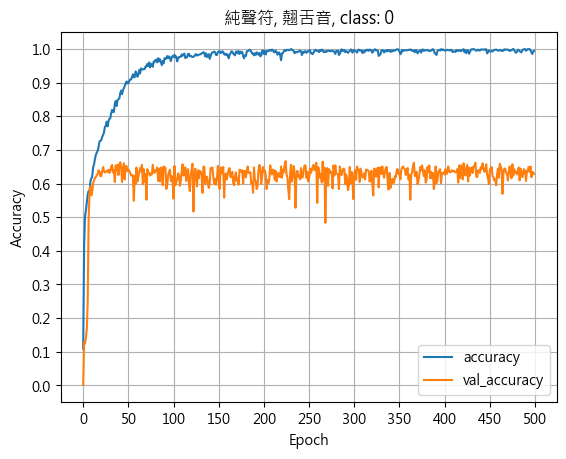

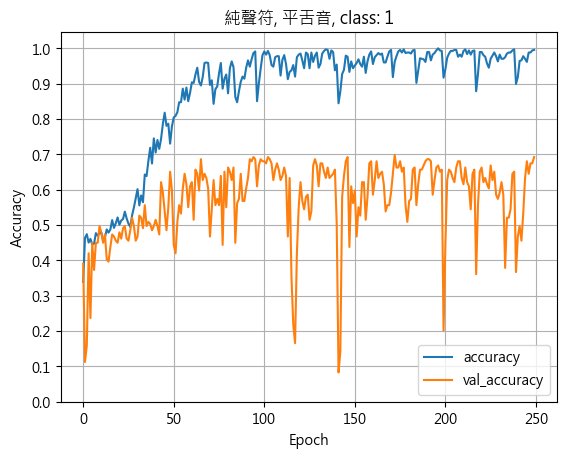

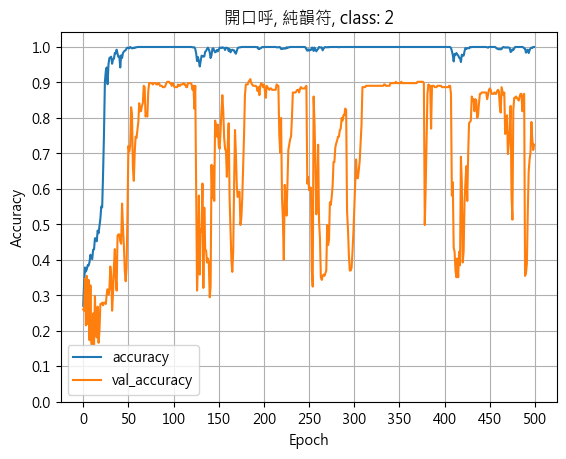

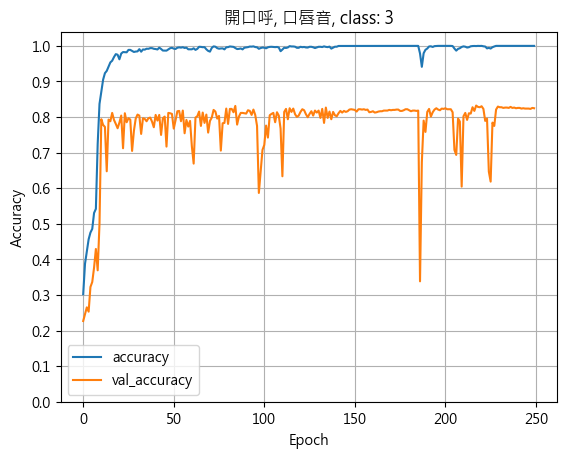

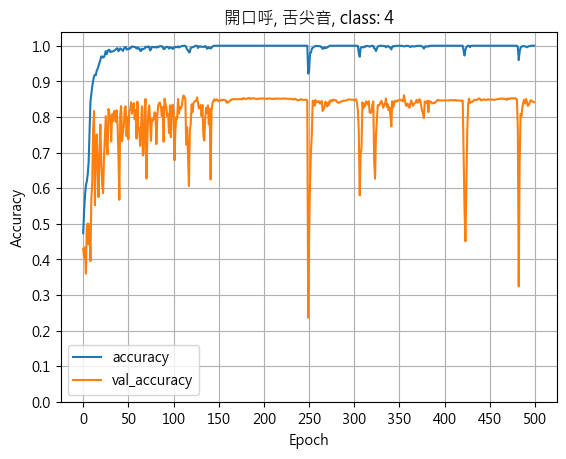

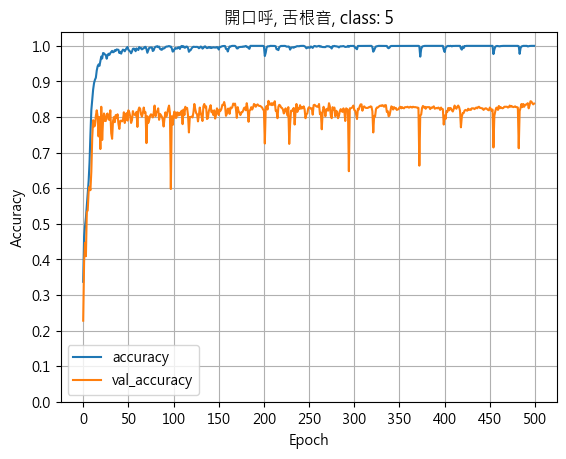

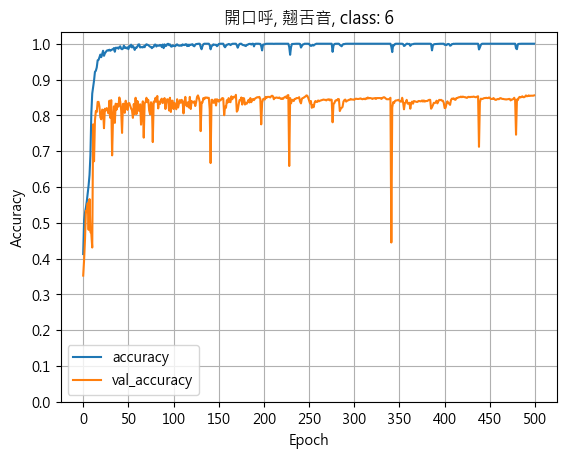

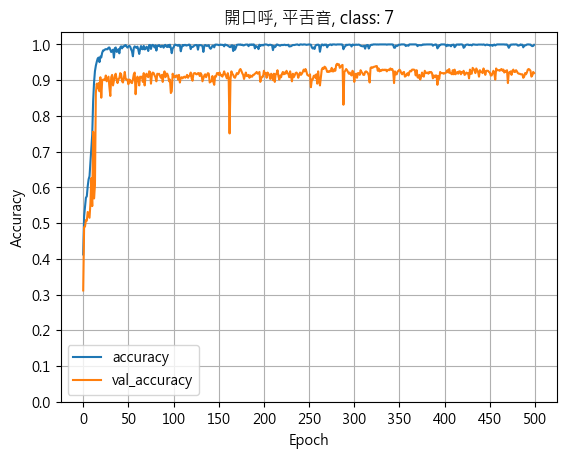

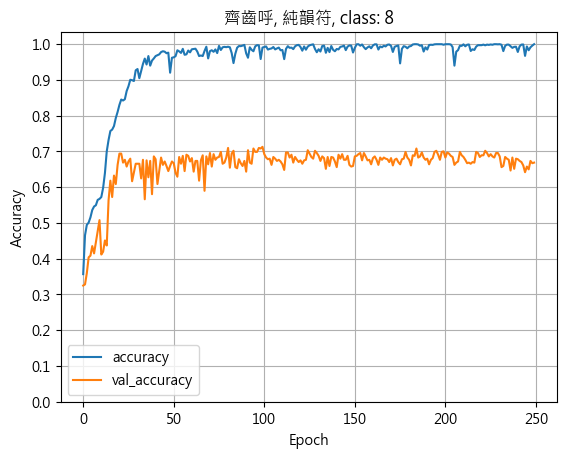

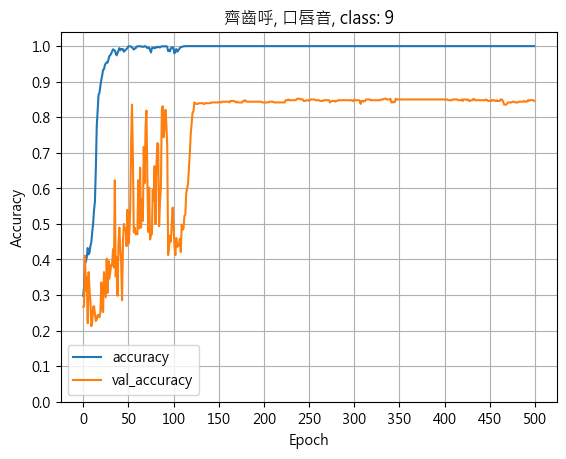

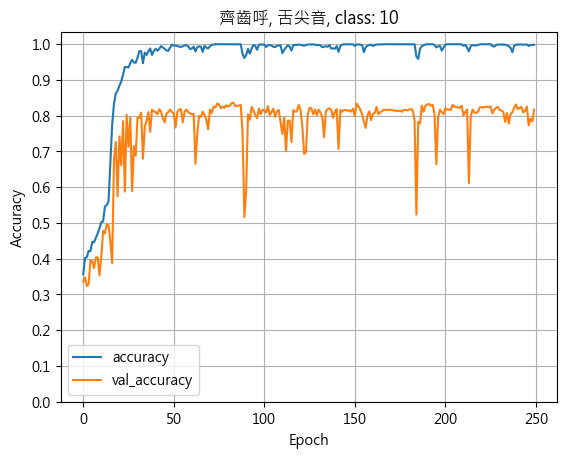

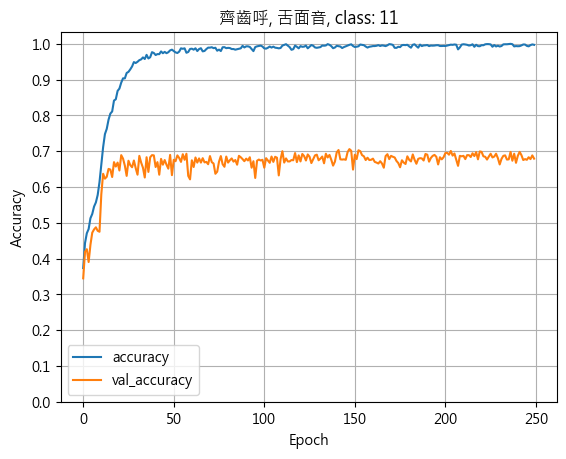

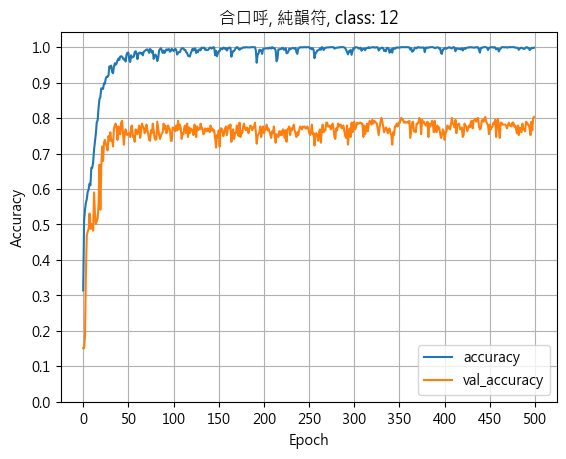

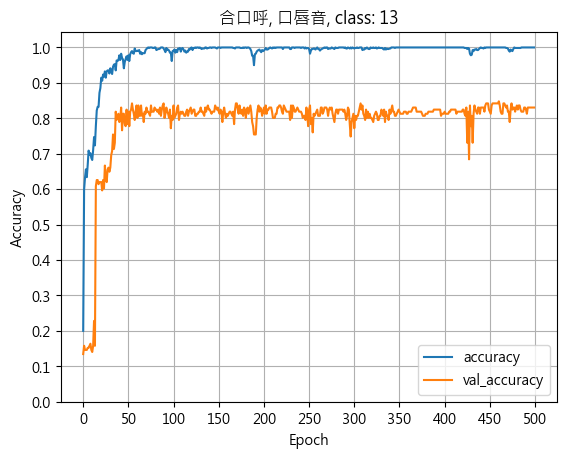

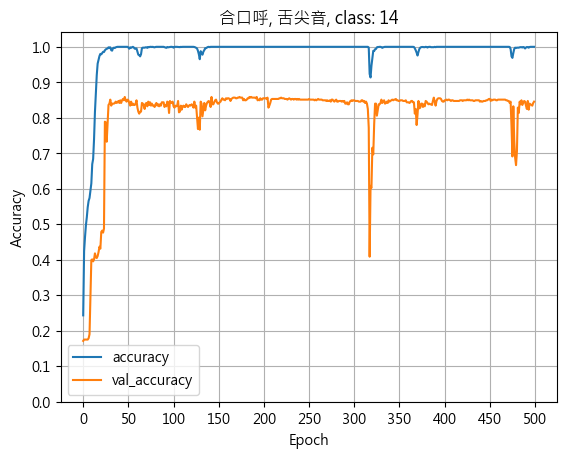

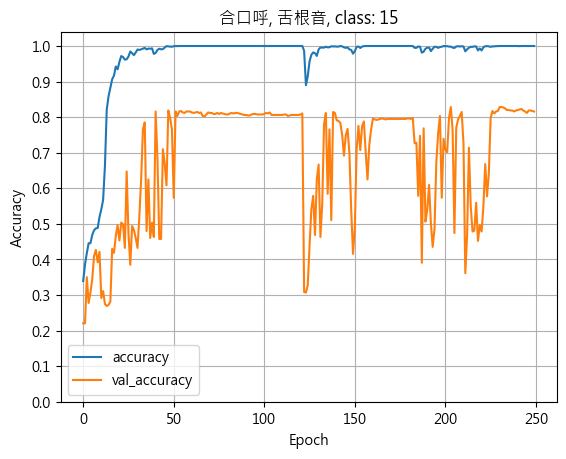

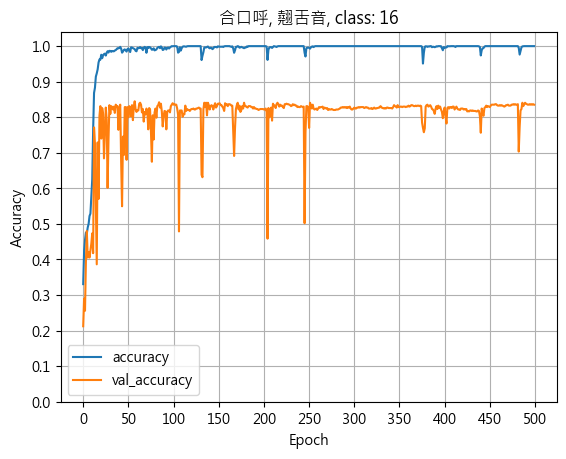

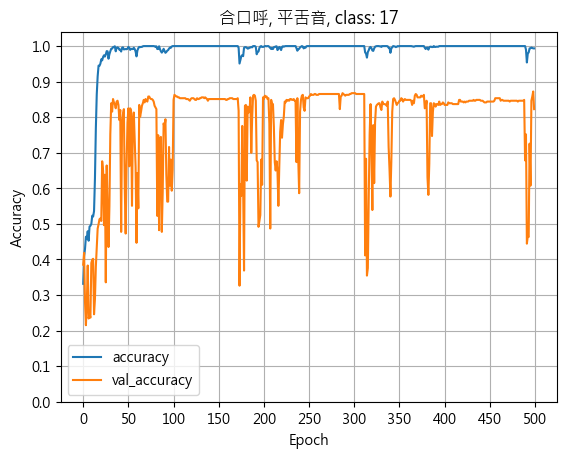

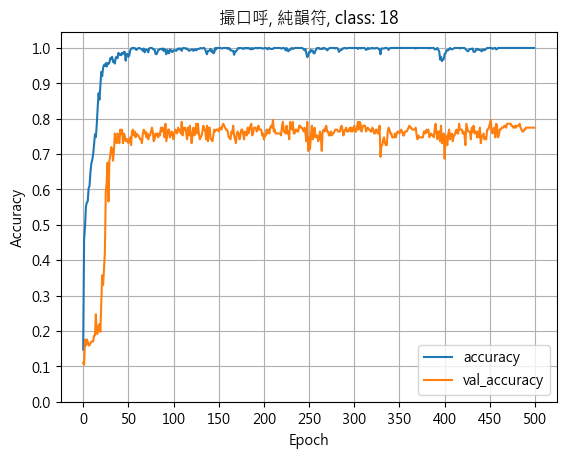

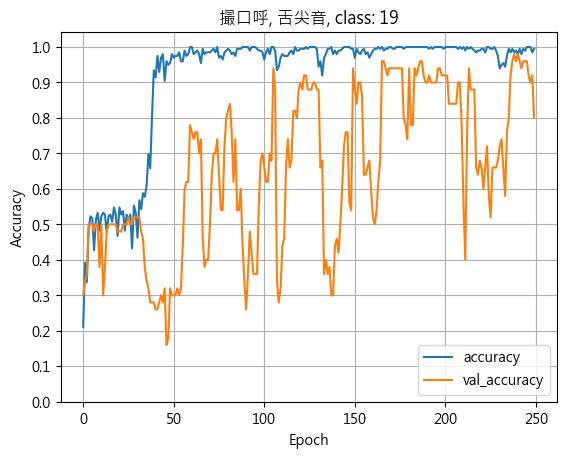

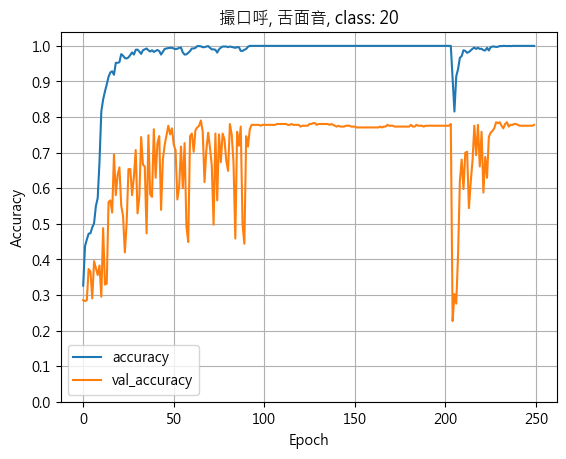

In [24]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False

for class_label, model_train_info in enumerate(model_train_info_list):
    accuracies = model_train_info.history['accuracy']
    val_accuracies = model_train_info.history['val_accuracy']
    
    best_params = json.load(
        open(
            file=f"..\\..\\grid_search\\method2_with_fake_data\\layer3\\best_parameters_record\\best_parameters_class{class_label}.json",
            mode="r"
        )
    )
    
    epochs = best_params["epochs"]
    
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    plt.title(f"{hu_yin}, {she2_yin}, class: {class_label}")
    
    plt.plot(list(range(epochs)), accuracies, label="accuracy")
    plt.plot(list(range(epochs)), val_accuracies, label="val_accuracy")
    plt.legend()
    plt.grid()
    plt.xticks(ticks = list(range(1, epochs + 1))) 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=list(range(0, epochs + 1, 50)))
    plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
    plt.show()

In [25]:
best_accuracy_list = list()

for class_label, model_train_info in enumerate(model_train_info_list):
    val_accuracies = model_train_info.history['val_accuracy']
    best_accuracy = max(val_accuracies)
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    print(f"class: {class_label}, {hu_yin}, {she2_yin}, 最高準確率: {best_accuracy}")
    best_accuracy_list.append(best_accuracy)

class: 0, 純聲符, 翹舌音, 最高準確率: 0.6666666865348816
class: 1, 純聲符, 平舌音, 最高準確率: 0.6982248425483704
class: 2, 開口呼, 純韻符, 最高準確率: 0.9094339609146118
class: 3, 開口呼, 口唇音, 最高準確率: 0.8322399258613586
class: 4, 開口呼, 舌尖音, 最高準確率: 0.8607856631278992
class: 5, 開口呼, 舌根音, 最高準確率: 0.8455555438995361
class: 6, 開口呼, 翹舌音, 最高準確率: 0.8572607040405273
class: 7, 開口呼, 平舌音, 最高準確率: 0.94590163230896
class: 8, 齊齒呼, 純韻符, 最高準確率: 0.7129337787628174
class: 9, 齊齒呼, 口唇音, 最高準確率: 0.8520833253860474
class: 10, 齊齒呼, 舌尖音, 最高準確率: 0.836320161819458
class: 11, 齊齒呼, 舌面音, 最高準確率: 0.7059206366539001
class: 12, 合口呼, 純韻符, 最高準確率: 0.8032345175743103
class: 13, 合口呼, 口唇音, 最高準確率: 0.847953200340271
class: 14, 合口呼, 舌尖音, 最高準確率: 0.8587570786476135
class: 15, 合口呼, 舌根音, 最高準確率: 0.8284518718719482
class: 16, 合口呼, 翹舌音, 最高準確率: 0.844897985458374
class: 17, 合口呼, 平舌音, 最高準確率: 0.8723404407501221
class: 18, 撮口呼, 純韻符, 最高準確率: 0.7967032790184021
class: 19, 撮口呼, 舌尖音, 最高準確率: 0.9800000190734863
class: 20, 撮口呼, 舌面音, 最高準確率: 0.790243923664093


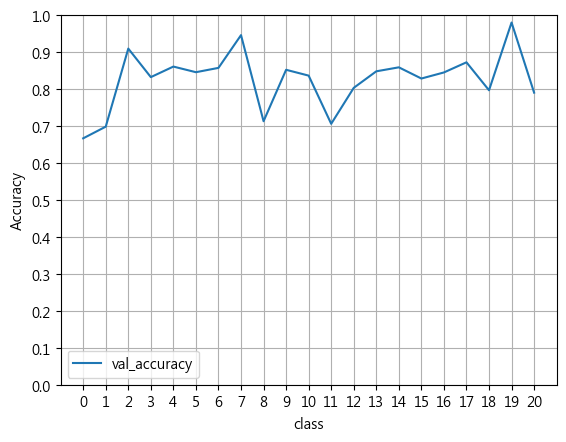

In [26]:
plt.plot(range(len(best_accuracy_list)), best_accuracy_list, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks=list(range(1, len(best_accuracy_list) + 1))) 
plt.xlabel("class")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(len(best_accuracy_list)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [29]:
model_dir_path = ".\\method2_layer3_models"
if not os.path.exists(model_dir_path):
    os.mkdir(model_dir_path)

for i, model in enumerate(model_list):
    model.save(filepath=f"{model_dir_path}\\class_{i}_model.h5")